# Feature Engineering

In [1]:
import logging
import os

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
from gensim.models import KeyedVectors
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

nltk.download("stopwords")
stopwords = nltk.corpus.stopwords.words("portuguese")

RANDOM_SEED = 19730115
NUMBER_OF_WORDS = 50
rng = np.random.RandomState(RANDOM_SEED)

logging.basicConfig(format="%(asctime)s - %(message)s", level=logging.INFO)
logging.info("Required packages installed.")


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/gomesluiz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
2022-11-24 00:12:09,013 - Required packages installed.


In [2]:
def load_dataset(path, stratify=False):
    """Get the data from csv file

    Args:
        path(str): the file complete path. 

    Returns:
        dataframe: A pandas dataframe.
    """
    dataset = pd.read_csv(path)

    if stratify:
        dataset = dataset.groupby('polarity', group_keys=False).apply(
            lambda x: x.sample(frac=0.4))
        dataset.reset_index(drop=True, inplace=True)

    return dataset


In [3]:
# Load the reviews datasets.
logging.info("Load the reviews datasets.")
reviews_train_dataset = load_dataset(
    "../data/processed/buscape_reviews_train_dataset.csv", True)
reviews_test_dataset = load_dataset(
    "../data/processed/buscape_reviews_test_dataset.csv", True)


2022-11-24 00:12:15,962 - Load the reviews datasets.


In [4]:
reviews_train_dataset.head()


,original_index,review_text,review_text_cleaned,review_text_cleaned_len,review_text_cleaned_no_stopwords,review_text_cleaned_len_no_stopwords,polarity
0,0_25105,Recebi uma amostra após ter comprando um perfu...,recebi uma amostra após ter comprando um perfu...,55,recebi amostra após ter comprando perfume site...,28,-1
1,0_430974,Dá muito problema no encanamento e faz muito b...,dá muito problema no encanamento e faz muito b...,9,dá problema encanamento faz barulho,5,-1
2,2_397554,BOA ATÉ PRECISAR DE ASSISTENCIA TÉCNICA E PEÇA...,boa até precisar de assistencia técnica e peça...,55,boa precisar assistencia técnica peçaso esiste...,30,-1
3,minus_2_325509,Não acho os produtos da Eletrolux bons.\nTodos...,não acho os produtos da eletrolux bons todos s...,120,acho produtos eletrolux bons todos problemátic...,66,-1
4,16_342529,Comprei este por ele ser mais acessivel (valor...,comprei este por ele ser mais acessivel valor ...,84,comprei acessivel valor barato outros embora p...,38,-1


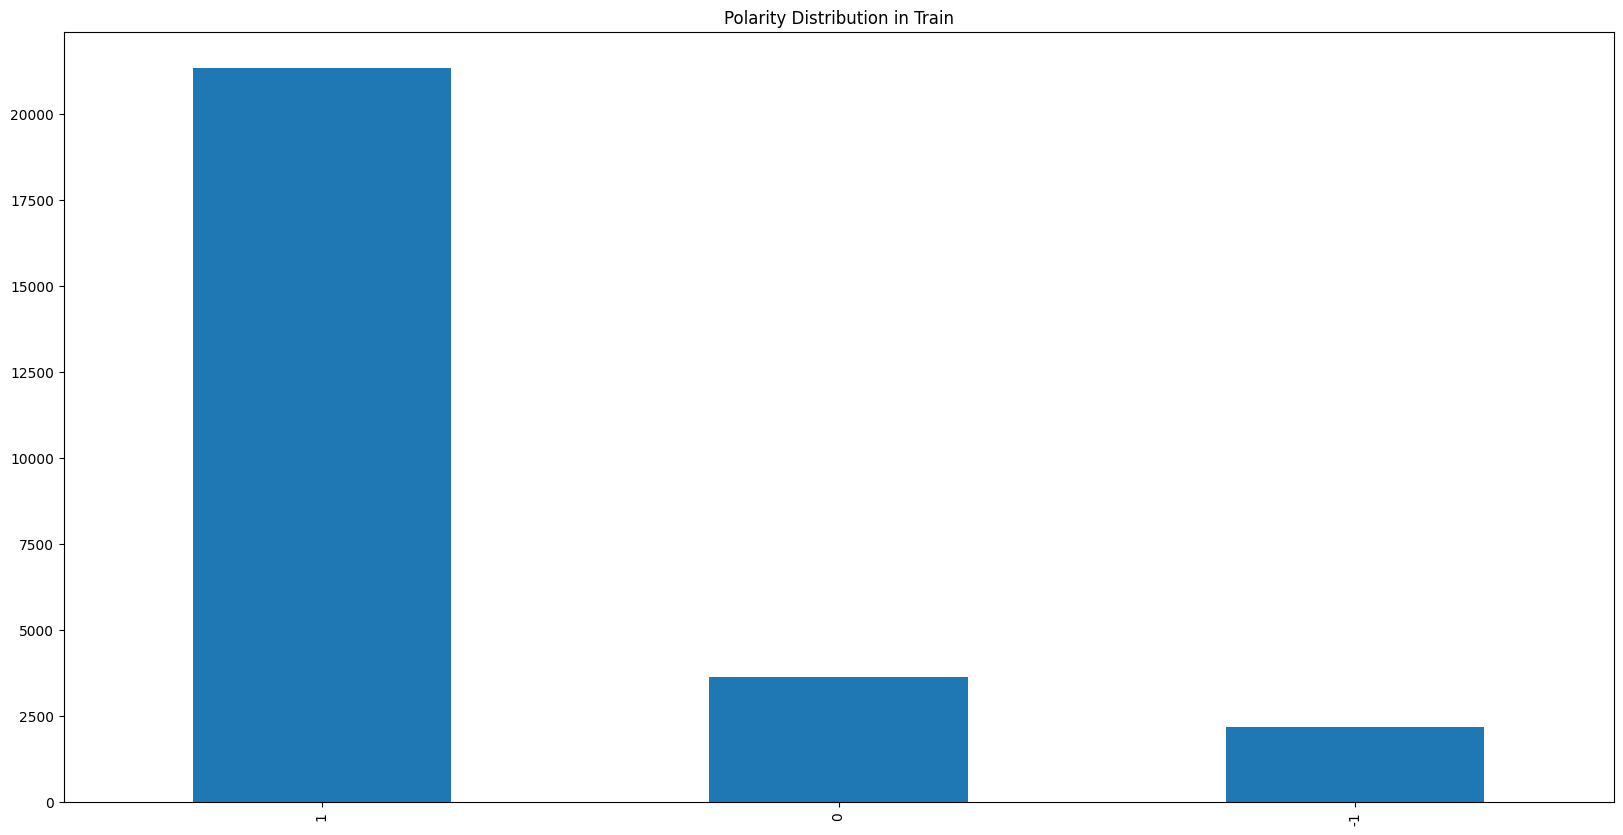

In [5]:
plt.figure(figsize=(20, 10))
plt.title('Polarity Distribution in Train')
_ = reviews_train_dataset['polarity'].value_counts().plot(kind='bar')

In [6]:
reviews_test_dataset.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6785 entries, 0 to 6784
Data columns (total 7 columns):
 #   Column                                Non-Null Count  Dtype 
---  ------                                --------------  ----- 
 0   original_index                        6785 non-null   object
 1   review_text                           6785 non-null   object
 2   review_text_cleaned                   6785 non-null   object
 3   review_text_cleaned_len               6785 non-null   int64 
 4   review_text_cleaned_no_stopwords      6785 non-null   object
 5   review_text_cleaned_len_no_stopwords  6785 non-null   int64 
 6   polarity                              6785 non-null   int64 
dtypes: int64(3), object(4)
memory usage: 371.2+ KB


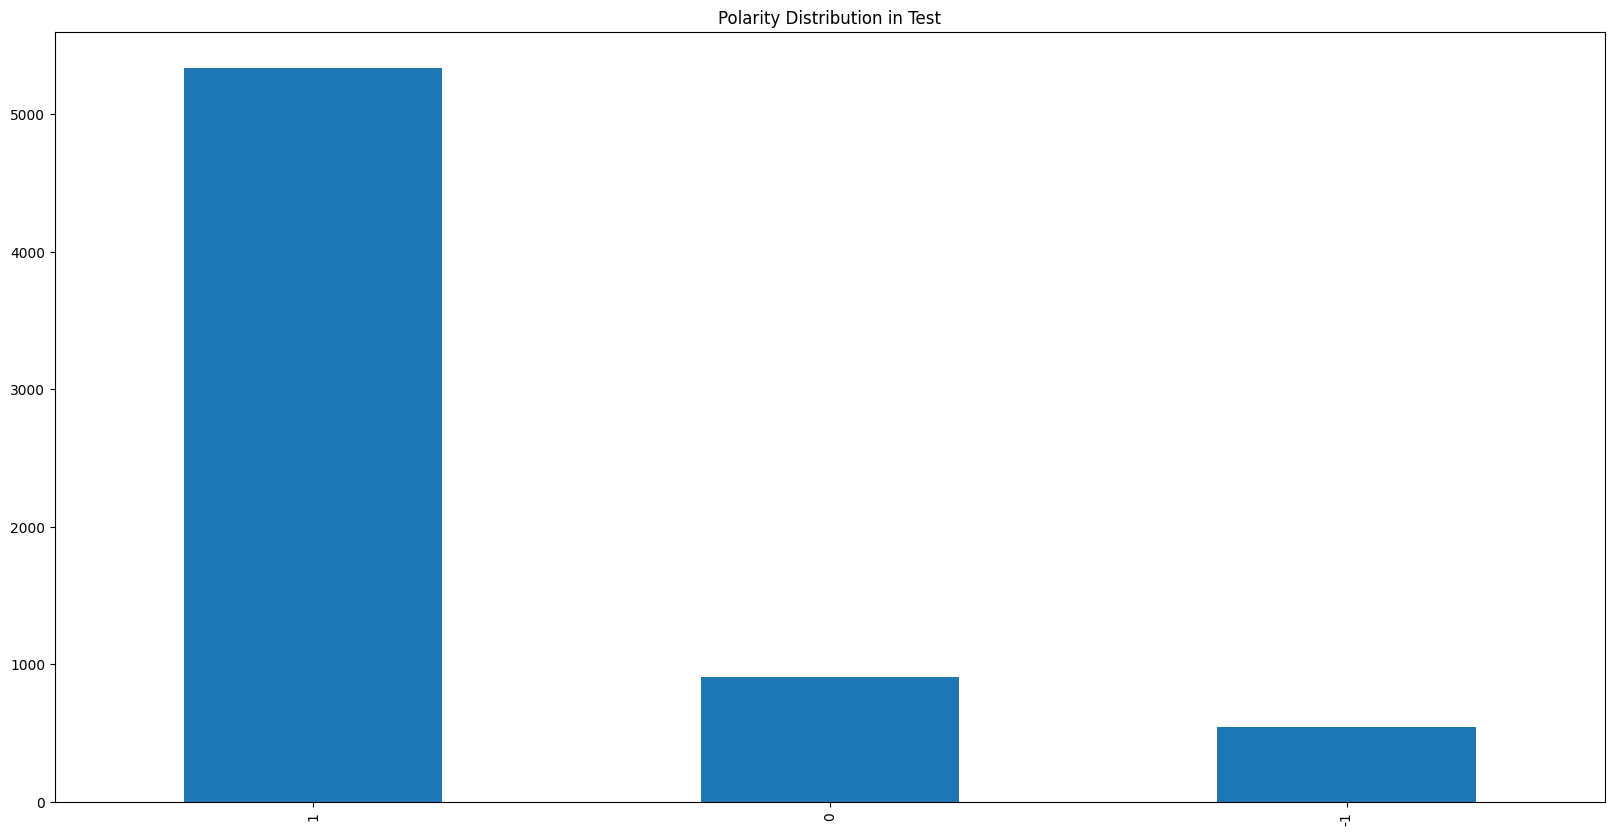

In [7]:
plt.figure(figsize=(20, 10))
plt.title('Polarity Distribution in Test')
_ = reviews_test_dataset['polarity'].value_counts().plot(kind='bar')

### Counter Vectorizer

In [8]:
cv = CountVectorizer(stop_words=stopwords, max_features=NUMBER_OF_WORDS)
reviews_train_cv = cv.fit_transform(
    reviews_train_dataset['review_text_cleaned_no_stopwords'])
reviews_train_dtm_cv = pd.DataFrame(
    reviews_train_cv.toarray(), columns=cv.get_feature_names_out())
reviews_train_dtm_cv.index = reviews_train_dataset.index
reviews_train_processed_cv = pd.concat([reviews_train_dataset[[
                                       'original_index']], reviews_train_dtm_cv, reviews_train_dataset[['polarity']]], axis=1)
logging.info(
    f"The counter vectorizer train matrix has {reviews_train_processed_cv.shape[0]} rows and {reviews_train_processed_cv.shape[1]} columns")

reviews_test_cv = cv.transform(
    reviews_test_dataset['review_text_cleaned_no_stopwords'])
reviews_test_dtm_cv = pd.DataFrame(
    reviews_test_cv.toarray(), columns=cv.get_feature_names_out())
reviews_test_dtm_cv.index = reviews_test_dataset.index
reviews_test_processed_cv = pd.concat([reviews_test_dataset[[
                                      'original_index']], reviews_test_dtm_cv, reviews_test_dataset[['polarity']]], axis=1)
logging.info(
    f"The counter vectorizer test matrix has {reviews_test_processed_cv.shape[0]} rows and {reviews_test_processed_cv.shape[1]} columns")


2022-11-24 00:12:42,358 - The counter vectorizer train matrix has 27138 rows and 52 columns
2022-11-24 00:12:42,568 - The counter vectorizer test matrix has 6785 rows and 52 columns


In [9]:
reviews_train_processed_cv.head(5)


,original_index,ainda,aparelho,bateria,bem,boa,bom,bonito,celular,compra,...,tempo,ter,todos,tudo,tv,usar,uso,ótima,ótimo,polarity
0,0_25105,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,-1
1,0_430974,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1
2,2_397554,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1
3,minus_2_325509,0,0,0,0,0,0,0,0,1,...,0,0,2,1,0,0,0,0,0,-1
4,16_342529,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,-1


In [10]:
reviews_test_processed_cv.head(5)


,original_index,ainda,aparelho,bateria,bem,boa,bom,bonito,celular,compra,...,tempo,ter,todos,tudo,tv,usar,uso,ótima,ótimo,polarity
0,0_398094,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,-1
1,0_457717,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1
2,0_197422,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,-1
3,5_345617,0,5,0,1,0,0,0,0,0,...,0,1,0,0,3,0,2,0,0,-1
4,1_57621,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1


In [11]:
reviews_train_processed_cv.to_pickle(
    f'../data/processed/buscape_reviews_train_dataset_cv_s{NUMBER_OF_WORDS}.pkl')
reviews_test_processed_cv.to_pickle(
    f'../data/processed/buscape_reviews_test_dataset_cv_s{NUMBER_OF_WORDS}.pkl')


### TF-IDF Vectorizer

In [12]:

tv = TfidfVectorizer(stop_words=stopwords, max_features=50)
reviews_train_tv = tv.fit_transform(reviews_train_dataset['review_text'])
reviews_train_dtm_tv = pd.DataFrame(
    reviews_train_tv.toarray(), columns=tv.get_feature_names_out())
reviews_train_dtm_tv.index = reviews_train_dataset.index
reviews_train_processed_tv = pd.concat([reviews_train_dataset[[
                                       'original_index']], reviews_train_dtm_tv, reviews_train_dataset[['polarity']]], axis=1)
logging.info(
    f"The tf-idf vectorizer train matrix has {reviews_train_processed_tv.shape[0]} rows and {reviews_train_processed_tv.shape[1]} columns")

reviews_test_tv = tv.transform(reviews_test_dataset['review_text'])
reviews_test_dtm_tv = pd.DataFrame(
    reviews_test_tv.toarray(), columns=tv.get_feature_names_out())
reviews_test_dtm_tv.index = reviews_test_dataset.index
reviews_test_processed_tv = pd.concat([reviews_test_dataset[[
                                      'original_index']], reviews_test_dtm_tv, reviews_test_dataset[['polarity']]], axis=1)
logging.info(
    f"The tf-idf vectorizer test matrix has {reviews_test_processed_tv.shape[0]} rows and {reviews_test_processed_tv.shape[1]} columns")


2022-11-24 00:12:58,993 - The tf-idf vectorizer train matrix has 27138 rows and 52 columns
2022-11-24 00:12:59,320 - The tf-idf vectorizer test matrix has 6785 rows and 52 columns


In [13]:
reviews_train_processed_tv.head(5)

,original_index,ainda,aparelho,bateria,bem,benefício,boa,bom,bonito,celular,...,tempo,ter,todos,tudo,tv,usar,uso,ótima,ótimo,polarity
0,0_25105,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,...,0.574749,0.510554,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,-1
1,0_430974,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,-1
2,2_397554,0.0,0.0,0.0,0.0,0.0,1.000000,0.00000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,-1
3,minus_2_325509,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,...,0.000000,0.000000,0.491524,0.243603,0.0,0.0,0.0,0.0,0.0,-1
4,16_342529,0.0,0.0,0.0,0.0,0.0,0.362008,0.27953,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,-1


In [14]:
reviews_train_processed_tv.to_pickle(
    f'../data/processed/buscape_reviews_train_dataset_tv_s{NUMBER_OF_WORDS}.pkl')
reviews_test_processed_tv.to_pickle(
    f'../data/processed/buscape_reviews_test_dataset_tv_s{NUMBER_OF_WORDS}.pkl')


### Embedding Vectorizer

In [15]:
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile


EMBEDDING_NAMES = [
    ["word2vec", "cbow_s50"],
    ["word2vec", "skip_s50"],
    ["fasttext", "cbow_s50"],
    ["fasttext", "skip_s50"],
    ["glove", "glove_s50"],
    ["wang2vec", "cbow_s50"],
    ["wang2vec", "skip_s50"],
]


def download_extract(model, architecture):
    """
    """
    url = f"http://143.107.183.175:22980/download.php?file=embeddings/{model}/{architecture}.zip"
    out_folder_path = os.path.join("../data/embeddings/", model)
    out_file_path = os.path.join(out_folder_path, architecture)
    logging.info(f"Downloading: {model}_{architecture}")
    if not os.path.exists(out_file_path):
        with urlopen(url) as response:
            with ZipFile(BytesIO(response.read())) as in_file_zip:
                in_file_zip.extractall(out_folder_path)


for model, architecture in EMBEDDING_NAMES:
    download_extract(model, architecture)


2022-11-24 00:13:15,818 - Downloading: word2vec_cbow_s50
2022-11-24 00:13:34,943 - Downloading: word2vec_skip_s50
2022-11-24 00:13:55,539 - Downloading: fasttext_cbow_s50
2022-11-24 00:14:19,964 - Downloading: fasttext_skip_s50
2022-11-24 00:14:39,896 - Downloading: glove_glove_s50
2022-11-24 00:15:00,110 - Downloading: wang2vec_cbow_s50
2022-11-24 00:15:21,022 - Downloading: wang2vec_skip_s50


In [16]:
# Load the pre-trainned fast text embedding.
logging.info("Load fast text embeddings.")
fasttext_cbow_s50 = KeyedVectors.load_word2vec_format(
    "../data/embeddings/fasttext/cbow_s50.txt"
)
fasttext_skip_s50 = KeyedVectors.load_word2vec_format(
    "../data/embeddings/fasttext/skip_s50.txt"
)


2022-11-24 00:16:46,187 - Load fast text embeddings.
2022-11-24 00:16:46,204 - loading projection weights from ../data/embeddings/fasttext/cbow_s50.txt


In [ ]:
# Load the pre-trainned glove embedding.
logging.info("Load glove embeddings.")
glove_s50 = KeyedVectors.load_word2vec_format("../data/embeddings/glove/glove_s50.txt")

2022-11-22 23:58:25,162 - Load glove embeddings.
2022-11-22 23:58:25,164 - loading projection weights from ../data/embeddings/glove/glove_s50.txt
2022-11-22 23:59:04,072 - KeyedVectors lifecycle event {'msg': 'loaded (929605, 50) matrix of type float32 from ../data/embeddings/glove/glove_s50.txt', 'binary': False, 'encoding': 'utf8', 'datetime': '2022-11-22T23:59:04.072670', 'gensim': '4.2.0', 'python': '3.10.8 (main, Nov  1 2022, 14:18:21) [GCC 12.2.0]', 'platform': 'Linux-6.0.9-arch1-1-x86_64-with-glibc2.36', 'event': 'load_word2vec_format'}


In [ ]:
# Load the pre-trainned wang2vec embedding.
logging.info("Load wang2vec embeddings.")
wang2vec_cbow_s50 = KeyedVectors.load_word2vec_format(
    "../data/embeddings/wang2vec/cbow_s50.txt"
)
wang2vec_skip_s50 = KeyedVectors.load_word2vec_format(
    "../data/embeddings/wang2vec/skip_s50.txt"
)

2022-11-22 23:59:17,030 - Load wang2vec embeddings.
2022-11-22 23:59:17,032 - loading projection weights from ../data/embeddings/wang2vec/cbow_s50.txt
2022-11-22 23:59:55,465 - KeyedVectors lifecycle event {'msg': 'loaded (929606, 50) matrix of type float32 from ../data/embeddings/wang2vec/cbow_s50.txt', 'binary': False, 'encoding': 'utf8', 'datetime': '2022-11-22T23:59:55.465002', 'gensim': '4.2.0', 'python': '3.10.8 (main, Nov  1 2022, 14:18:21) [GCC 12.2.0]', 'platform': 'Linux-6.0.9-arch1-1-x86_64-with-glibc2.36', 'event': 'load_word2vec_format'}
2022-11-22 23:59:55,466 - loading projection weights from ../data/embeddings/wang2vec/skip_s50.txt
2022-11-23 00:00:34,854 - KeyedVectors lifecycle event {'msg': 'loaded (929606, 50) matrix of type float32 from ../data/embeddings/wang2vec/skip_s50.txt', 'binary': False, 'encoding': 'utf8', 'datetime': '2022-11-23T00:00:34.854913', 'gensim': '4.2.0', 'python': '3.10.8 (main, Nov  1 2022, 14:18:21) [GCC 12.2.0]', 'platform': 'Linux-6.0.9-arc

In [ ]:
# Load the pre-trainned word2vec embedding.
logging.info("Load word2vec embeddings.")
word2vec_cbow_s50 = KeyedVectors.load_word2vec_format(
    '../data/embeddings/word2vec/cbow_s50.txt')
word2vec_skip_s50 = KeyedVectors.load_word2vec_format(
    '../data/embeddings/word2vec/skip_s50.txt')


2022-11-23 00:01:37,542 - Load word2vec embeddings.
2022-11-23 00:01:37,544 - loading projection weights from ../data/embeddings/word2vec_cbow_s50/cbow_s50.txt
2022-11-23 00:02:16,169 - KeyedVectors lifecycle event {'msg': 'loaded (929606, 50) matrix of type float32 from ../data/embeddings/word2vec_cbow_s50/cbow_s50.txt', 'binary': False, 'encoding': 'utf8', 'datetime': '2022-11-23T00:02:16.168986', 'gensim': '4.2.0', 'python': '3.10.8 (main, Nov  1 2022, 14:18:21) [GCC 12.2.0]', 'platform': 'Linux-6.0.9-arch1-1-x86_64-with-glibc2.36', 'event': 'load_word2vec_format'}
2022-11-23 00:02:16,170 - loading projection weights from ../data/embeddings/word2vec_skip_s50/skip_s50.txt
2022-11-23 00:02:55,467 - KeyedVectors lifecycle event {'msg': 'loaded (929606, 50) matrix of type float32 from ../data/embeddings/word2vec_skip_s50/skip_s50.txt', 'binary': False, 'encoding': 'utf8', 'datetime': '2022-11-23T00:02:55.466868', 'gensim': '4.2.0', 'python': '3.10.8 (main, Nov  1 2022, 14:18:21) [GCC 12

In [ ]:
# def text_to_bert(text)
def text_to_embedding(text, model, vectorizer=None, vocab=None, size=50):
    if not vectorizer:
        raise Exception("The vectorizer parameter must not be None")

    transformed = vectorizer.transform(text)
    vectorized = pd.DataFrame(transformed.toarray(
    ), columns=vectorizer.get_feature_names_out())

    embeedings = pd.DataFrame()
    for i in range(vectorized.shape[0]):
        sentence = np.zeros(size)
        for word in vocab[vectorized.iloc[i, :] > 0]:
            if model.get_index(word, default=-1) != -1:
                sentence = sentence + model.get_vector(word)
            else:
                print("Out of Vocabulary")

        embeedings = pd.concat([embeedings, pd.DataFrame([sentence])])

    return embeedings


In [ ]:
embedding_models = [fasttext_cbow_s50, fasttext_skip_s50, glove_s50,
                    wang2vec_cbow_s50, wang2vec_skip_s50, word2vec_cbow_s50, word2vec_skip_s50]

for name, model in zip(EMBEDDING_NAMES, embedding_models):
    reviews_train_dtm = text_to_embedding(
        reviews_train_dataset['review_text'], model, tv, reviews_test_processed_tv.columns[1:-1], 50)
    reviews_train_processed = pd.concat([reviews_train_dataset.reset_index()[['original_index']], reviews_train_dtm.reset_index(
        drop=True), reviews_train_dataset.reset_index()[['polarity']]], axis=1, ignore_index=True)
    reviews_train_processed.to_pickle(
        f"../data/processed/buscape_reviews_train_dataset_{name[0]}_{name[1]}.pkl")
    print(
        f"The {name} vectorized train dataframe has {reviews_train_processed.shape[0]} rows and {reviews_train_processed.shape[1]} columns")

    reviews_test_dtm = text_to_embedding(
        reviews_test_dataset['review_text'], model, tv, reviews_test_processed_tv.columns[1:-1], 50)
    reviews_test_processed = pd.concat([reviews_test_dataset.reset_index()[['original_index']], reviews_test_dtm.reset_index(
        drop=True), reviews_test_dataset.reset_index()[['polarity']]], axis=1, ignore_index=True)
    reviews_test_processed.to_pickle(
        f"../data/processed/buscape_reviews_test_dataset_{name[0]}_{name[1]}.pkl")
    print(
        f"The {name} vectorized test dataframe has {reviews_test_processed.shape[0]} rows and {reviews_test_processed.shape[1]} columns")


The ['word2vec', 'cbow_s50'] vectorizer train dataframe has 27138 rows and 52 columns
The ['word2vec', 'cbow_s50'] vectorizer test dataframe has 6785 rows and 52 columns
The ['word2vec', 'skip_s50'] vectorizer train dataframe has 27138 rows and 52 columns
The ['word2vec', 'skip_s50'] vectorizer test dataframe has 6785 rows and 52 columns
The ['fasttext', 'cbow_s50'] vectorizer train dataframe has 27138 rows and 52 columns
The ['fasttext', 'cbow_s50'] vectorizer test dataframe has 6785 rows and 52 columns
The ['fasttext', 'skip_s50'] vectorizer train dataframe has 27138 rows and 52 columns
The ['fasttext', 'skip_s50'] vectorizer test dataframe has 6785 rows and 52 columns
The ['glove', 'glove_s50'] vectorizer train dataframe has 27138 rows and 52 columns
The ['glove', 'glove_s50'] vectorizer test dataframe has 6785 rows and 52 columns
The ['wang2vec', 'cbow_s50'] vectorizer train dataframe has 27138 rows and 52 columns
The ['wang2vec', 'cbow_s50'] vectorizer test dataframe has 6785 rows

In [ ]:
import torch

from transformers import AutoTokenizer
from transformers import AutoModel

model = AutoModel.from_pretrained("neuralmind/bert-base-portuguese-cased")
logging.info(f"Transformers model class model: {type(model)}")
tokenizer = AutoTokenizer.from_pretrained(
    "neuralmind/bert-base-portuguese-cased", do_lower_case=True
)
logging.info(f"Transformers tokenizer class: {type(tokenizer)}")


# Create a function to tokenize a set of texts
def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=sent,  # Preprocess sentence
            add_special_tokens=True,     # Add `[CLS]` and `[SEP]`
            max_length=64,               # Max length to truncate/pad
            padding='max_length',        # Pad sentence to max length
            truncation='only_first',     # Truncate sentence to max length
            return_attention_mask=True,  # Return attention mask
        )

        # Add the outputs to the lists
        input_ids.append(encoded_sent.get("input_ids"))
        attention_masks.append(encoded_sent.get("attention_mask"))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks


review_train_inputs, review_train_masks = preprocessing_for_bert(
    list(reviews_train_dataset["review_text"])
)
with torch.no_grad():
    outs = model(review_train_inputs, review_train_masks)
    review_train_bert_encoded = outs[0][:, 0, :]

review_test_inputs, review_test_masks = preprocessing_for_bert(
    list(reviews_test_dataset["review_text"])
)
with torch.no_grad():
    outs = model(review_test_inputs, review_test_masks)
    review_test_bert_encoded = outs[0][:, 0, :]

/home/gomesluiz/Workspace/product-review-analytics/.venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the che

In [ ]:
reviews_train_processed_bert = pd.concat(
    [
        reviews_train_dataset[["original_index"]],
        review_train_bert_encoded,
        reviews_train_dataset[["polarity"]],
    ],
    axis=1,
)
reviews_train_processed_bert.to_pickle(f"../data/processed/buscape_reviews_train_dataset_bert.pkl")   

NameError: name 'pd' is not defined